# Summarize Results

This notebook reads outputs and creates several common model output summaries such as trip lengths, mode shares, etc.

# Imports

In [1]:
import pandas as pd
import numpy as np
import openmatrix as omx
import os

import matplotlib.pyplot as plt # !pip install matplotlib # for charts
import geopandas as gpd # !conda install geopandas # for making maps
import descartes # !conda install descartes # for making maps

# Utilities

Specify the output folder for an existing model run.  Note that the included example is a small sample of households and so the resulting summaries will be quite sparse.  Specify a folder for output verification summaries.  

In [9]:
OUTPUT_DIR = '../test_example_mtc/output'
VERIF_DIR = os.path.join(OUTPUT_DIR, 'verification')
if not os.path.exists(VERIF_DIR):
    os.mkdir(VERIF_DIR)

def save_verf_csv(dataframe, filename, index=True, header=True, 
                  na_rep=0, verification_folder=VERIF_DIR):
    path = os.path.join(verification_folder, filename)
    dataframe.to_csv(path, header=header, index=index, na_rep=na_rep)


# Check and Read Inputs

These might need to change depending on which example has been run! Check your example folder for exact file names.

In [18]:
ZONES_FILE = os.path.join(OUTPUT_DIR, 'final_land_use.csv')
ACCESS_FILE = os.path.join(OUTPUT_DIR, 'final_accessibility.csv')
HH_FILE = os.path.join(OUTPUT_DIR, 'final_households.csv')
PERSON_FILE = os.path.join(OUTPUT_DIR, 'final_persons.csv')
TOUR_FILE = os.path.join(OUTPUT_DIR, 'final_tours.csv')
TRIPS_FILE = os.path.join(OUTPUT_DIR, 'final_trips.csv')

DISTANCE_MATRIX_FILE = os.path.join(OUTPUT_DIR, '../data/skims.omx')
NMTF_ALTS_FILE = os.path.join(OUTPUT_DIR, '../configs', 'non_mandatory_tour_frequency_alternatives.csv')
SHAPE_FILE = os.path.join('zone_shapefile', 'bayarea_rtaz1454_rev1.shp')

for file in [ZONES_FILE,
             ACCESS_FILE,
             HH_FILE,
             PERSON_FILE,
             TOUR_FILE,
             TRIPS_FILE,
             DISTANCE_MATRIX_FILE,
             NMTF_ALTS_FILE,
             SHAPE_FILE]:
    if not os.path.exists(file):
        raise FileNotFoundError("Make sure %s exists before proceding to next step!" % file)
    else:
        print("file found: ", file)

file found:  ../test_example_mtc/output\final_land_use.csv
file found:  ../test_example_mtc/output\final_accessibility.csv
file found:  ../test_example_mtc/output\final_households.csv
file found:  ../test_example_mtc/output\final_persons.csv
file found:  ../test_example_mtc/output\final_tours.csv
file found:  ../test_example_mtc/output\final_trips.csv
file found:  ../test_example_mtc/output\../data/skims.omx
file found:  ../test_example_mtc/output\../configs\non_mandatory_tour_frequency_alternatives.csv
file found:  zone_shapefile\bayarea_rtaz1454_rev1.shp


# Load tables

Read tables into memory

In [19]:
DIST_MAT = omx.open_file(DISTANCE_MATRIX_FILE)["DIST"][:]

TAZ = pd.read_csv(ZONES_FILE, index_col='TAZ')
HOUSEHOLD = pd.read_csv(HH_FILE, index_col='household_id')
PERSON = pd.read_csv(PERSON_FILE, index_col='person_id')
TOUR = pd.read_csv(TOUR_FILE, index_col='tour_id')
TRIP = pd.read_csv(TRIPS_FILE, index_col='trip_id')

SHAPES = gpd.read_file(SHAPE_FILE)

## Add useful columns for verification

In [20]:
PERSON_TYPES = ["", "Full-time worker", "Part-time worker", "University student", "Non-worker",
          "Retired", "Student of driving age", "Student of non-driving age",
          "Child too young for school"]

MODE_LABELS = ["", "DRIVEALONEFREE", "DRIVEALONEPAY", "SHARED2FREE", "SHARED2PAY", "SHARED3FREE",
               "SHARED3PAY", "WALK", "BIKE", "WALK_LOC", "WALK_LRF", "WALK_EXP", "WALK_HVY",
               "WALK_COM", "DRIVE_LOC", "DRIVE_LRF", "DRIVE_EXP", "DRIVE_HVY", "DRIVE_COM"]

PERSON["ptypename"] = pd.Series(PERSON_TYPES)[PERSON["ptype"].tolist()].tolist()
TOUR["tour_mode"] = pd.Categorical(TOUR["tour_mode"], categories=MODE_LABELS)
TRIP["trip_mode"] = pd.Categorical(TRIP["trip_mode"], categories=MODE_LABELS)

# Matplot Default Chart Settings

In [21]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

# Household and Person

## Auto ownership

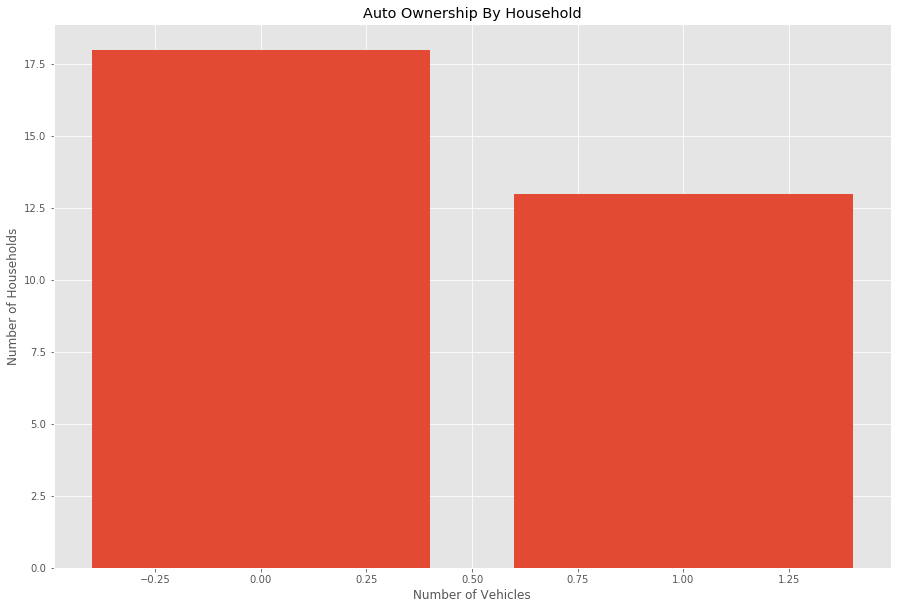

In [28]:
autos = HOUSEHOLD.groupby(["TAZ", "auto_ownership"]).count()["income"]
auto_taz = autos.reset_index().pivot_table(index="TAZ", columns="auto_ownership", fill_value=0)

save_verf_csv(auto_taz, 'autos.csv')

auto_counts = autos.groupby(["auto_ownership"]).count()
plt.bar(auto_counts.index, auto_counts.values)
plt.title('Auto Ownership By Household')
plt.ylabel('Number of Households')
_ = plt.xlabel('Number of Vehicles')

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


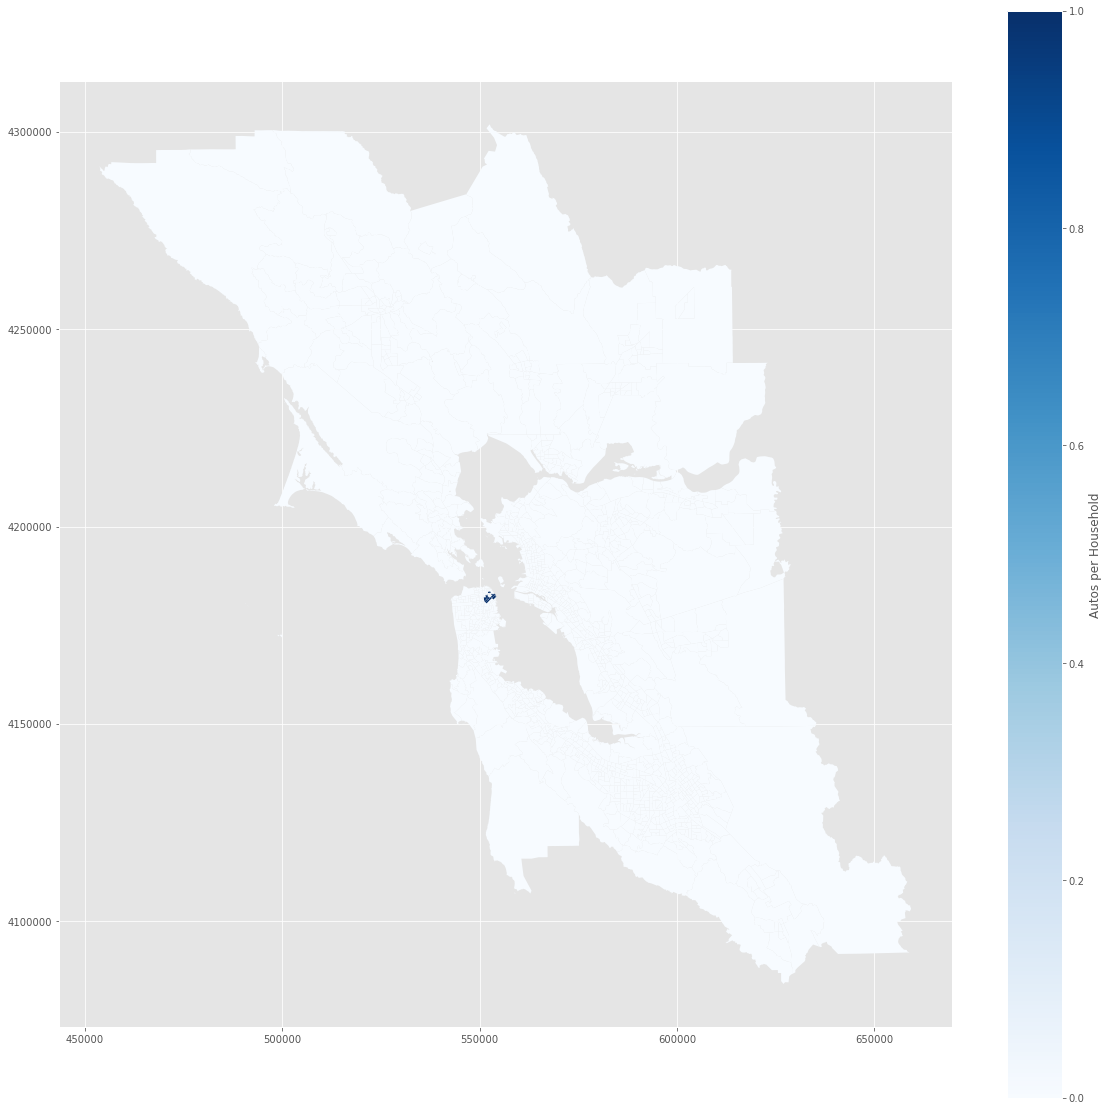

In [29]:
auto_shapes = SHAPES.merge(autos.reset_index(), how='left', left_on='TAZ1454', right_on='TAZ')
auto_shapes.plot(column='auto_ownership', cmap='Blues',
                 legend=True,
                 legend_kwds={'label': "Autos per Household"},
                 figsize=(20,20))

## CDAP activity by person type

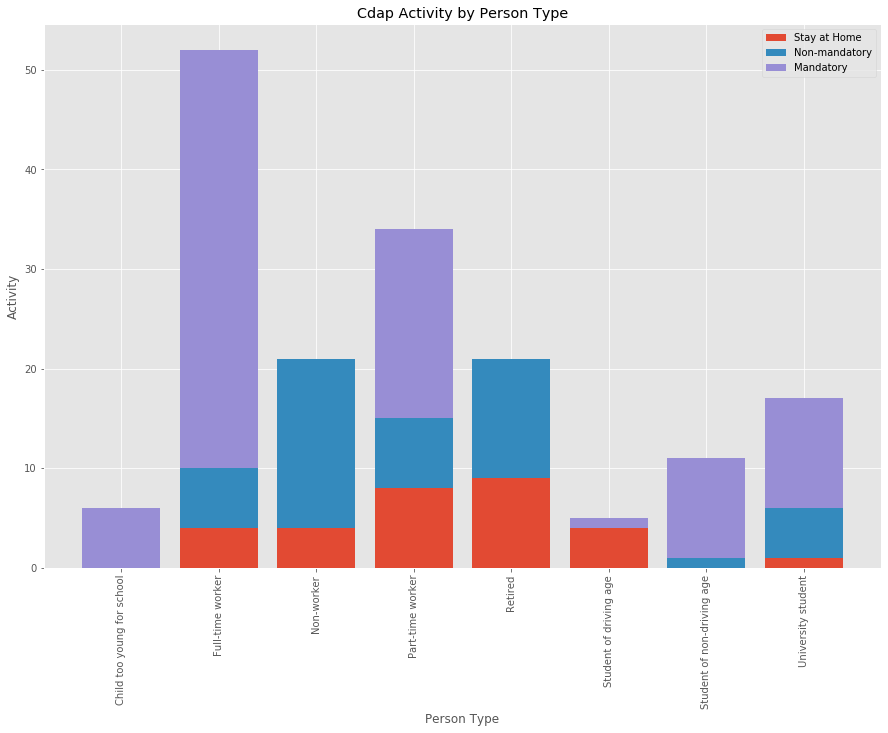

In [30]:
cdap_sum = PERSON.groupby(["ptypename", "cdap_activity"]).count()["household_id"]
cdap_sum = cdap_sum.reset_index().pivot_table(index="ptypename", columns="cdap_activity", fill_value=0)

save_verf_csv(cdap_sum, 'cdap.csv')

stay_at_home = cdap_sum['household_id']['H']
n_mand = cdap_sum['household_id']['N']
mand = cdap_sum['household_id']['M']
plt.bar(cdap_sum.index, stay_at_home, label='Stay at Home')
plt.bar(cdap_sum.index, n_mand, label= 'Non-mandatory', bottom=stay_at_home)
plt.bar(cdap_sum.index, mand, label='Mandatory', bottom=stay_at_home+n_mand)

plt.title('Cdap Activity by Person Type')
plt.ylabel('Activity')
plt.xlabel('Person Type')
plt.xticks(rotation='vertical')
_ = plt.legend(loc='best')

## Free parking by ptype

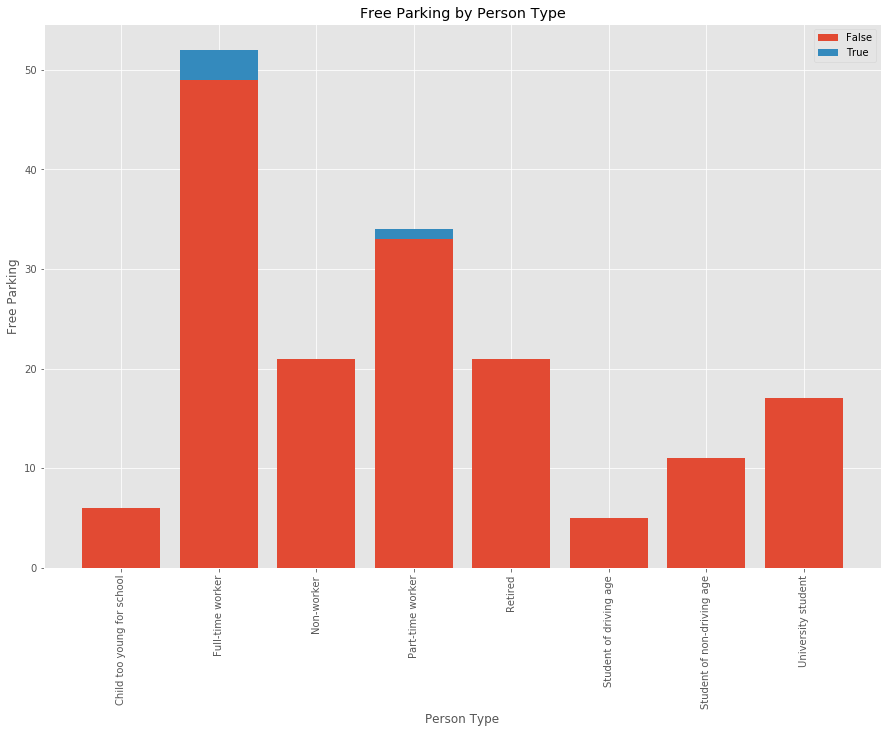

In [31]:
fp = PERSON.groupby(["ptypename", "free_parking_at_work"]).count()["household_id"]
fp = fp.reset_index().pivot_table(index="ptypename", columns="free_parking_at_work", fill_value=0)

save_verf_csv(fp, 'free_parking.csv')

plt.bar(fp.index, fp['household_id'][0], label='False')
plt.bar(fp.index, fp['household_id'][1], label='True', bottom=fp['household_id'][0])
plt.title('Free Parking by Person Type')
plt.ylabel('Free Parking')
plt.xlabel('Person Type')
plt.xticks(rotation='vertical')
_ = plt.legend(loc='best')

## Value of time

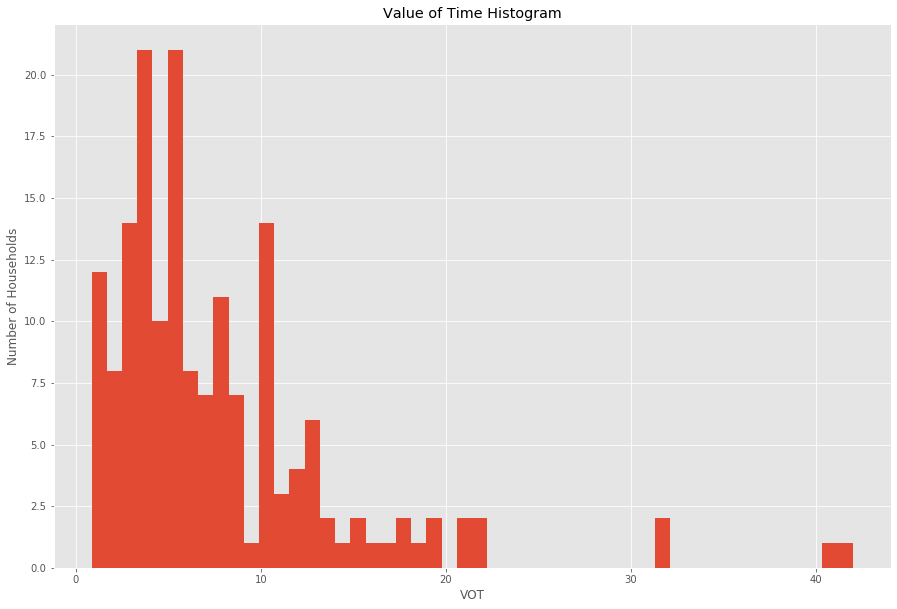

In [32]:
PERSON["vot_bin"] = pd.cut(PERSON["value_of_time"], range(51))
vot = PERSON.groupby(["vot_bin"]).count()["household_id"]

save_verf_csv(vot, 'vot.csv')
plt.hist(PERSON['value_of_time'], bins=50)
plt.title('Value of Time Histogram')
plt.ylabel('Number of Households')
_ = plt.xlabel('VOT')

# Tour

## Individual mandatory tour frequency

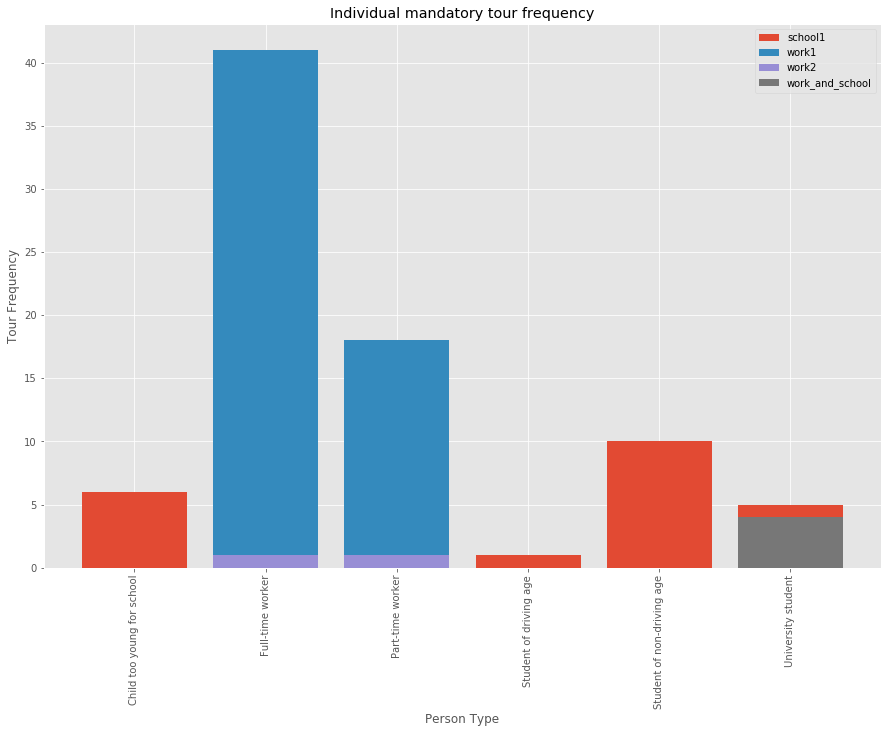

In [33]:
PERSON["hhsize"] = HOUSEHOLD["hhsize"].loc[PERSON["household_id"]].tolist()
imtf = PERSON.groupby(["ptypename", "mandatory_tour_frequency"]).count()["household_id"]
imtf = imtf.reset_index().pivot_table(index="ptypename", columns="mandatory_tour_frequency", fill_value=0)

save_verf_csv(imtf, 'imtf.csv')

for col in imtf['household_id'].columns:
    plt.bar(imtf.index, imtf['household_id'][col], label=col)

plt.title('Individual mandatory tour frequency')
plt.ylabel('Tour Frequency')
plt.xlabel('Person Type')
plt.xticks(rotation='vertical')
_ = plt.legend(loc='best')

## Individual mandatory tour scheduling

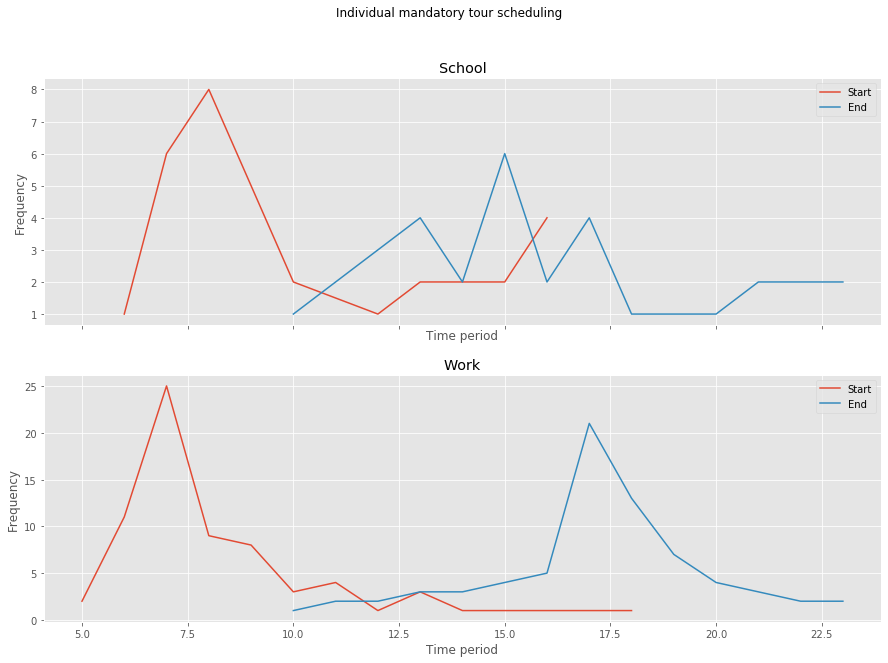

In [34]:
tours_man = TOUR[TOUR["tour_category"] == "mandatory"]
mtdd = tours_man.groupby(["start", "end", "tour_type"]).count()["household_id"].reset_index()

mtdd_sch = mtdd[mtdd["tour_type"] == "school"][[
    "start", "end", "household_id"]].pivot_table(index="start", columns="end", fill_value=0)['household_id']
mtdd_work = mtdd[mtdd["tour_type"] == "work"][[
    "start", "end", "household_id"]].pivot_table(index="start", columns="end", fill_value=0)['household_id']

save_verf_csv(mtdd_sch, 'mtdd_school.csv')
save_verf_csv(mtdd_work, 'mtdd_work.csv')

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Individual mandatory tour scheduling')
ax1.plot(mtdd_sch.sum(axis=1), label='Start')
ax1.plot(mtdd_sch.sum(axis=0), label='End')
ax1.set_title('School')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Time period')
ax1.legend(loc='best')

ax2.plot(mtdd_work.sum(axis=1), label='Start')
ax2.plot(mtdd_work.sum(axis=0), label='End')
ax2.set_title('Work')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Time period')
_ = ax2.legend(loc='best')

## Joint tour frequency

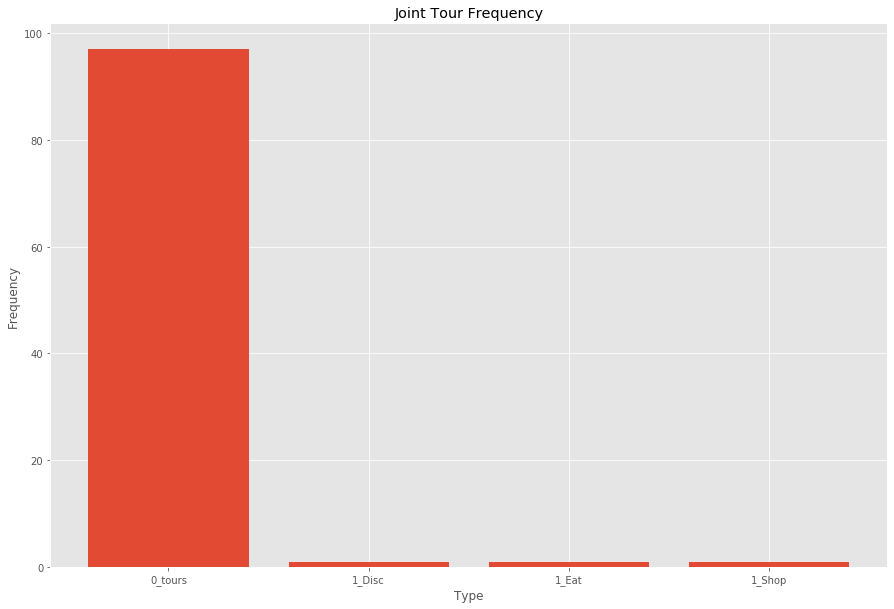

In [35]:
jtf = HOUSEHOLD[HOUSEHOLD['joint_tour_frequency'] != '']
jtf = jtf.reset_index().groupby('joint_tour_frequency').count()['household_id']

save_verf_csv(jtf, 'jtf.csv')
plt.bar(jtf.index, jtf.values)
plt.title('Joint Tour Frequency')
plt.ylabel('Frequency')
_ = plt.xlabel('Type')

## Joint tour composition

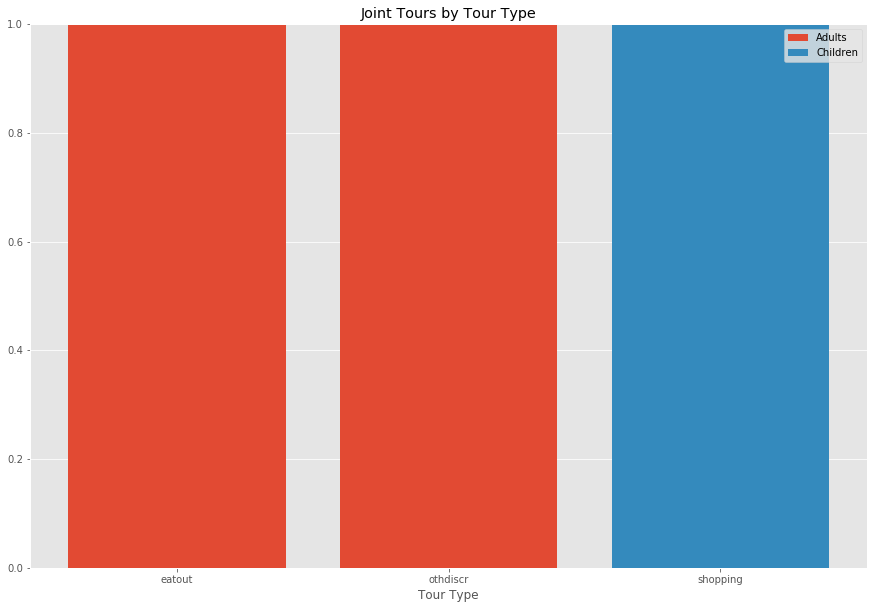

In [52]:
JOINT_TOURS = TOUR[TOUR["tour_category"] == "joint"]
jtour_comp = JOINT_TOURS.groupby(["tour_type", "composition"]).count()["household_id"].reset_index()
jtour_comp = jtour_comp.pivot_table(index="tour_type", columns="composition", fill_value=0)

save_verf_csv(jtour_comp, 'jtour_comp.csv')
adults = jtour_comp['household_id']['adults']
children = jtour_comp['household_id']['children']
if "mixed" in JOINT_TOURS.composition.tolist():
    mixed = jtour_comp['household_id']['mixed']

plt.bar(jtour_comp.index, adults, label='Adults')
plt.bar(jtour_comp.index, children, label='Children', bottom = adults)

if "mixed" in JOINT_TOURS.composition.tolist():
   plt.bar(jtour_comp.index, mixed, label='Mixed', bottom = adults+children)

plt.title('Joint Tours by Tour Type')
plt.xlabel('Tour Type')
_ = plt.legend(loc='best')

## Joint tour destination

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\programdata\anaconda3\envs\asimtest\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


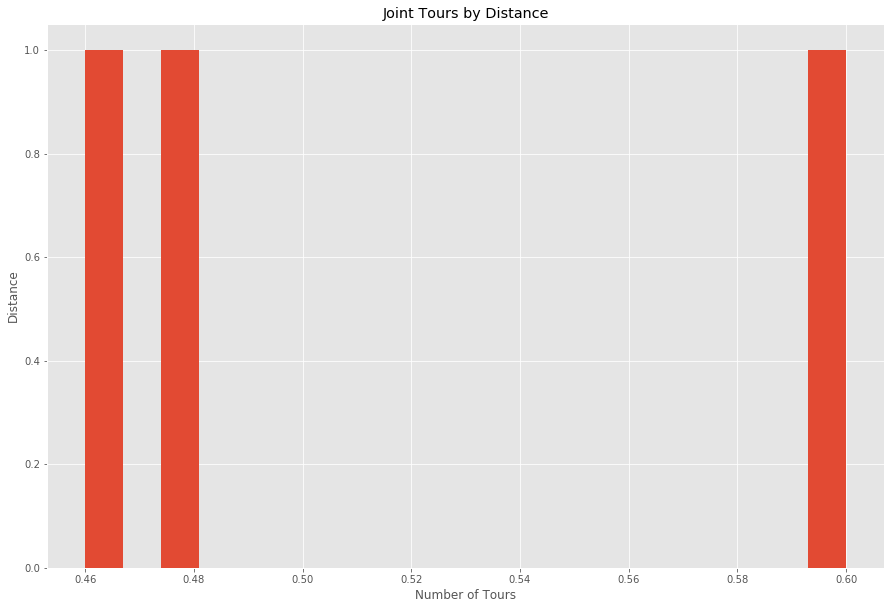

In [53]:
JOINT_TOURS["distance"] = DIST_MAT[JOINT_TOURS["origin"].astype(int)-1,
                                   JOINT_TOURS["destination"].astype(int)-1]
JOINT_TOURS["dist_bin"] = pd.cut(JOINT_TOURS["distance"], range(21))
jtours_dist = JOINT_TOURS.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(jtours_dist, 'jtour_dist.csv')
plt.hist(JOINT_TOURS["distance"], bins=20)
plt.title('Joint Tours by Distance')
plt.ylabel('Distance')
_ = plt.xlabel('Number of Tours')

## Joint tour scheduling

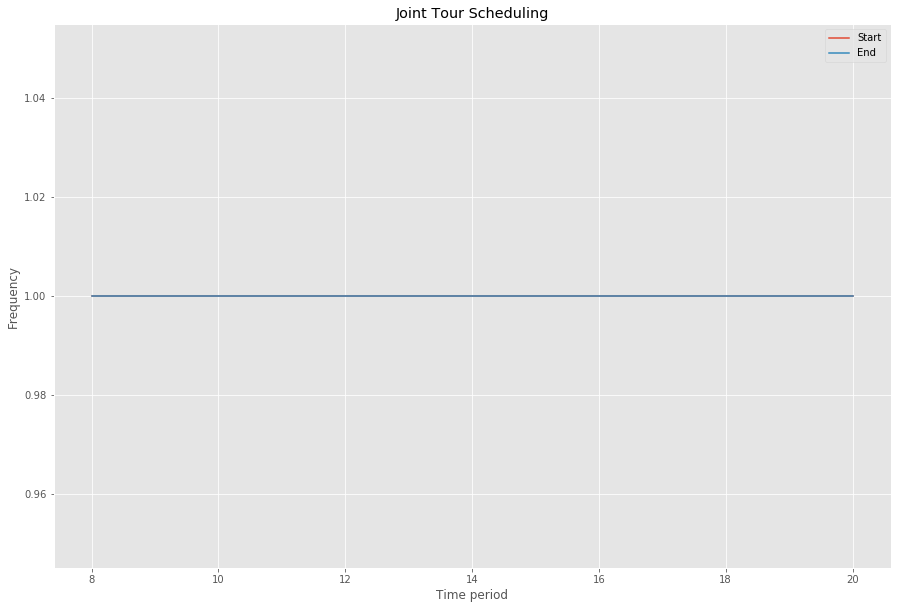

In [54]:
jtours_tdd = JOINT_TOURS.groupby(["start", "end"]).count()["household_id"].reset_index()
jtours_tdd = jtours_tdd.pivot_table(index="start", columns="end", fill_value=0)['household_id']

save_verf_csv(jtours_tdd, 'jtours_tdd.csv')

plt.plot(jtours_tdd.sum(axis=1), label='Start')
plt.plot(jtours_tdd.sum(axis=0), label='End')
plt.title('Joint Tour Scheduling')
plt.ylabel('Frequency')
plt.xlabel('Time period')
_ = plt.legend(loc='best')

## Non-mandatory tour frequency

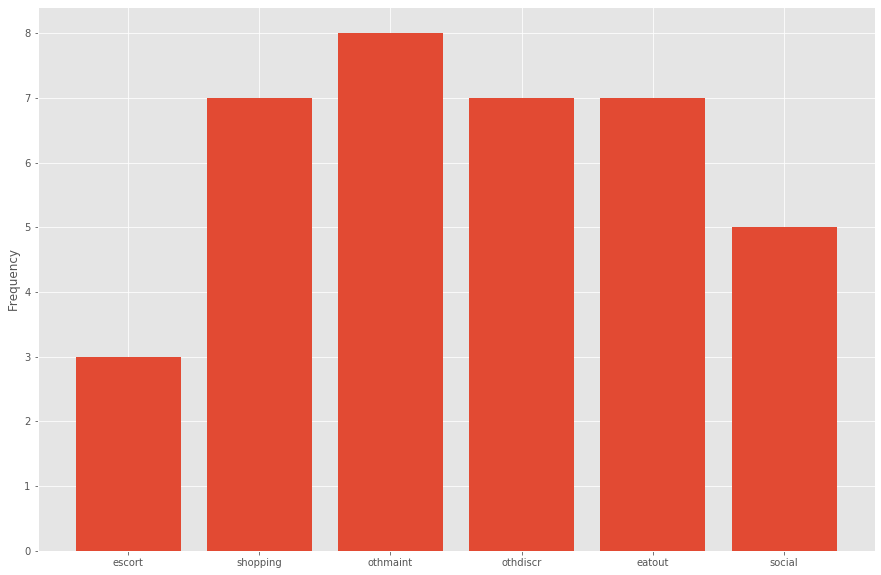

In [55]:
alts = pd.read_csv(NMTF_ALTS_FILE)
alts["ID"] = range(len(alts))

nmtf_sum = PERSON.groupby(["non_mandatory_tour_frequency"]).count()["household_id"]
nmtf_alts = pd.concat([alts, nmtf_sum], axis=1).dropna()

save_verf_csv(nmtf_alts, 'nmtf.csv')
nmtf = nmtf_alts.drop(['ID', 'household_id'], axis=1).sum()
plt.bar(nmtf.index, nmtf.values)
_ = plt.ylabel('Frequency')

## Non-mandatory tour destination

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\anaconda3\envs\asimtest\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


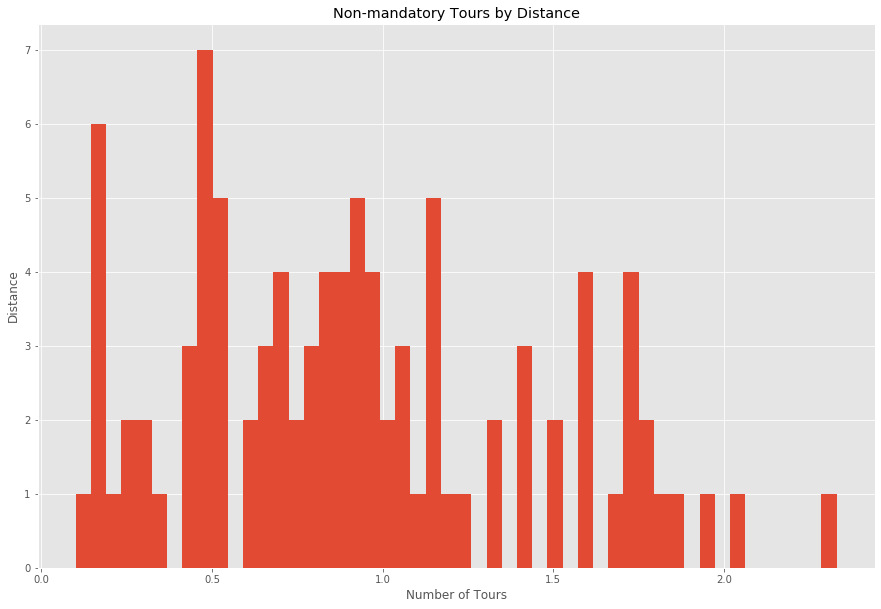

In [56]:
nm_tours = TOUR[TOUR["tour_category"] == "non_mandatory"]
nm_tours["distance"] = DIST_MAT[nm_tours["origin"].astype(int)-1,
                                nm_tours["destination"].astype(int)-1]
nm_tours["dist_bin"] = pd.cut(nm_tours["distance"], range(51))
nm_tours_dist = nm_tours.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(nm_tours_dist, 'nmtd_dist.csv')
plt.hist(nm_tours["distance"], bins=50)
plt.title('Non-mandatory Tours by Distance')
plt.ylabel('Distance')
_ = plt.xlabel('Number of Tours')

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


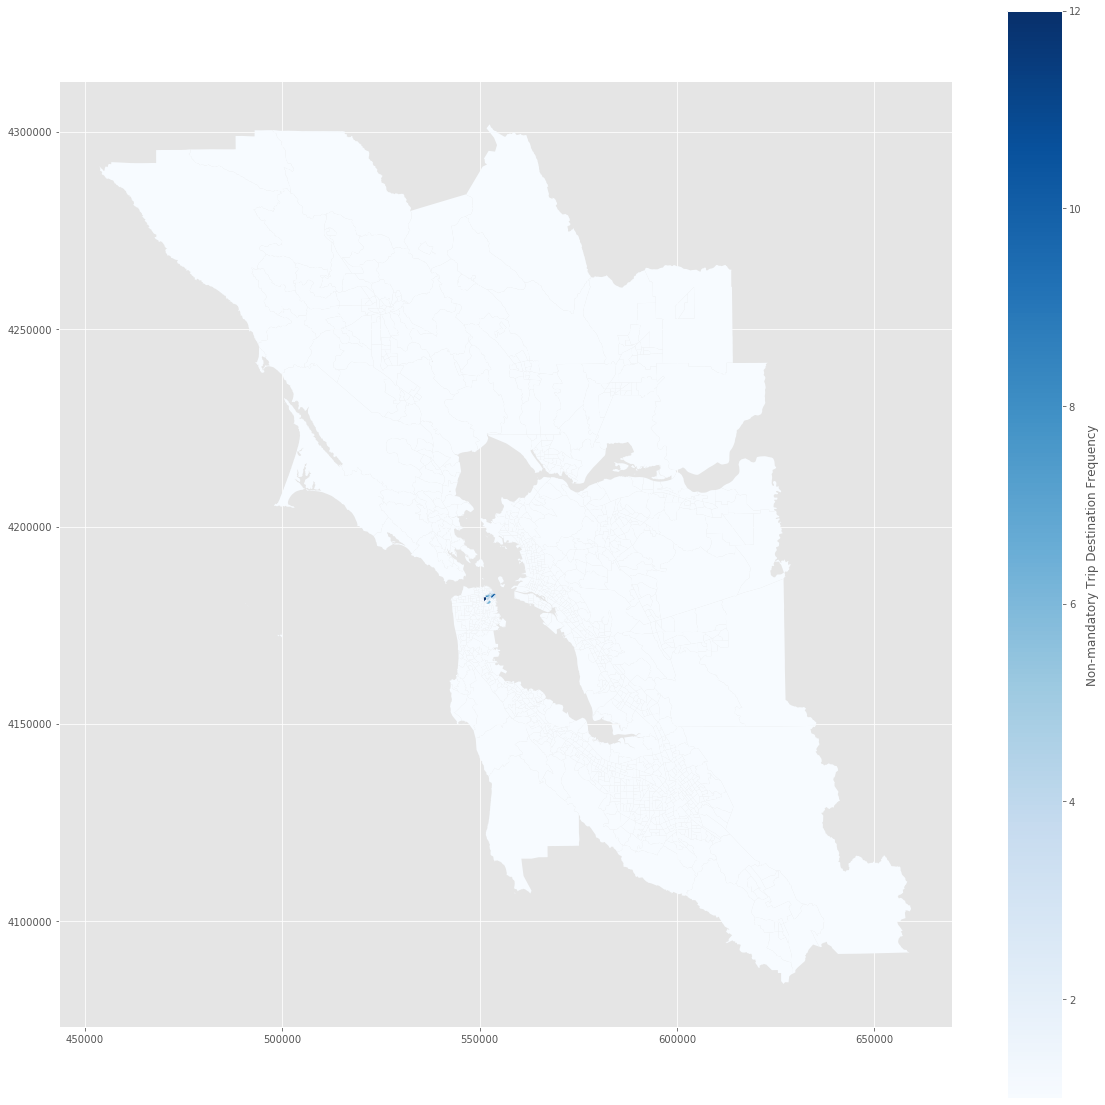

In [57]:
nmtours_dests = nm_tours.groupby(['destination']).count()['household_id']
nmtours_shapes = SHAPES.merge(nmtours_dests.reset_index(), how='left', left_on='TAZ1454', right_on='destination')
nmtours_shapes.plot(column='household_id', 
                    cmap='Blues',
                    figsize=(20,20),
                    legend=True,
                    legend_kwds={'label': 'Non-mandatory Trip Destination Frequency'})

## Non-mandatory tour scheduling

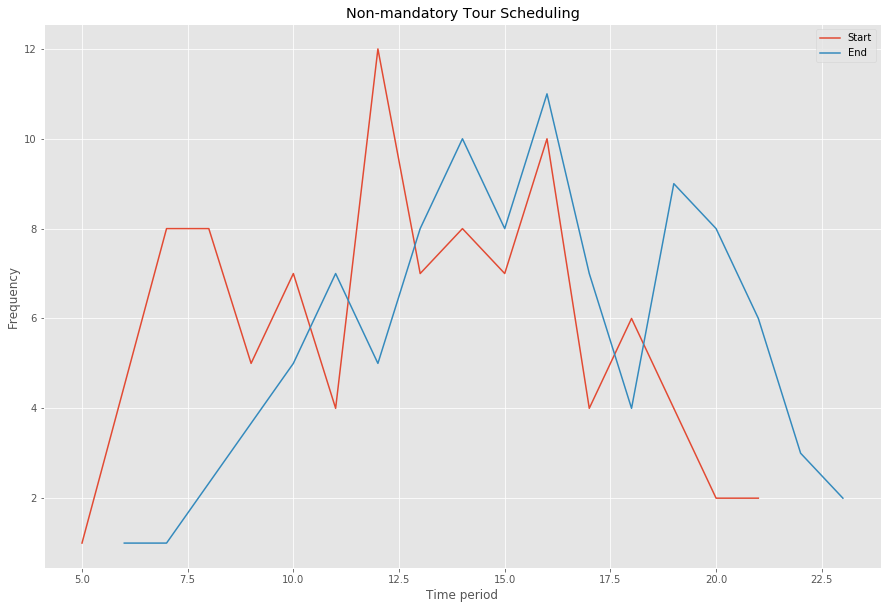

In [69]:
nmtours_tdd = nm_tours.groupby(["start", "end"]).count()["household_id"].reset_index()
nmtours_tdd = nmtours_tdd.pivot_table(index="start", columns="end", fill_value=0)["household_id"]

save_verf_csv(nmtours_tdd, 'nmtours_tdd.csv')

plt.plot(nmtours_tdd.sum(axis=1), label='Start')
plt.plot(nmtours_tdd.sum(axis=0), label='End')
plt.title('Non-mandatory Tour Scheduling')
plt.ylabel('Frequency')
plt.xlabel('Time period')
_ = plt.legend(loc='best')

## Tour mode choice

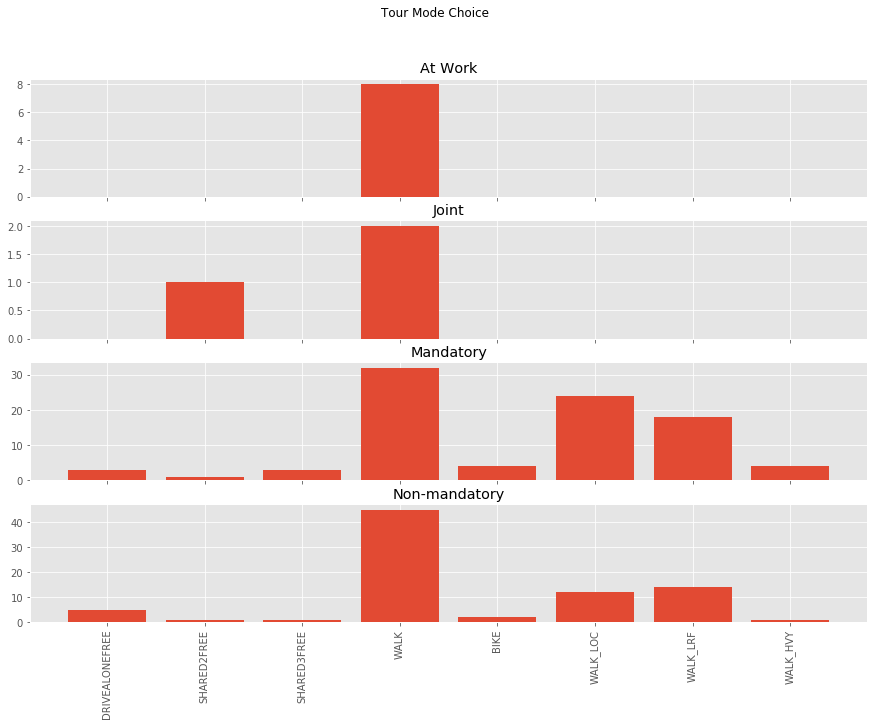

In [59]:
tour_mode = TOUR.groupby(["tour_mode", "tour_category"]).count()["household_id"].reset_index()
tour_mode = tour_mode.pivot_table(index="tour_mode", columns="tour_category", fill_value=0)['household_id']

save_verf_csv(tour_mode, 'tour_mode.csv')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Tour Mode Choice')
ax1.bar(tour_mode.index, tour_mode['atwork'])
ax1.set_title('At Work')
ax2.bar(tour_mode.index, tour_mode['joint'])
ax2.set_title('Joint')
ax3.bar(tour_mode.index, tour_mode['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(tour_mode.index, tour_mode['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')

## At-work subtour frequency 

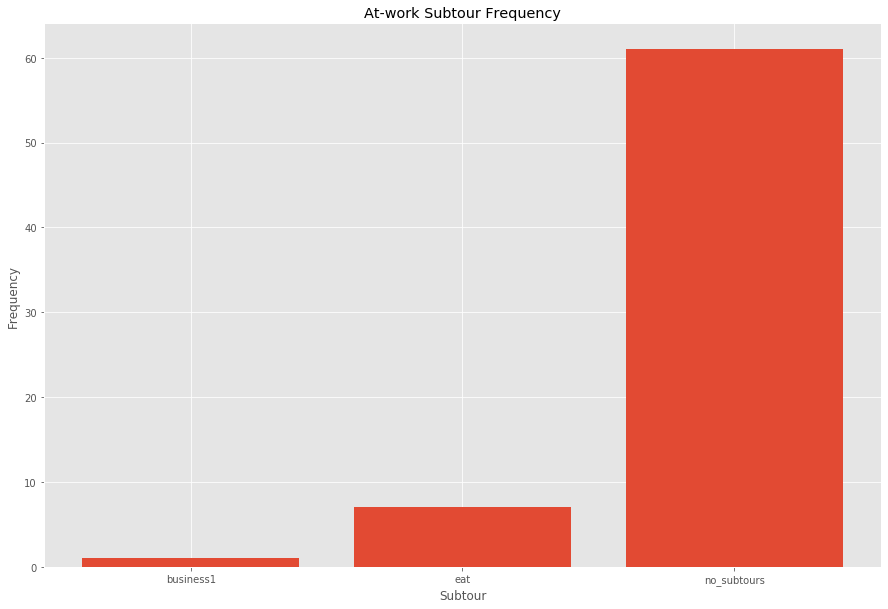

In [71]:
work_tours = TOUR[TOUR["primary_purpose"] == "work"]
work_tours = work_tours.groupby(["atwork_subtour_frequency"]).count()["household_id"]

save_verf_csv(work_tours, 'atwork_tf.csv')
plt.bar(work_tours.index, work_tours.values)
plt.title('At-work Subtour Frequency')
plt.xlabel('Subtour')
_ = plt.ylabel('Frequency')

## At-work subtour destination

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\anaconda3\envs\asimtest\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


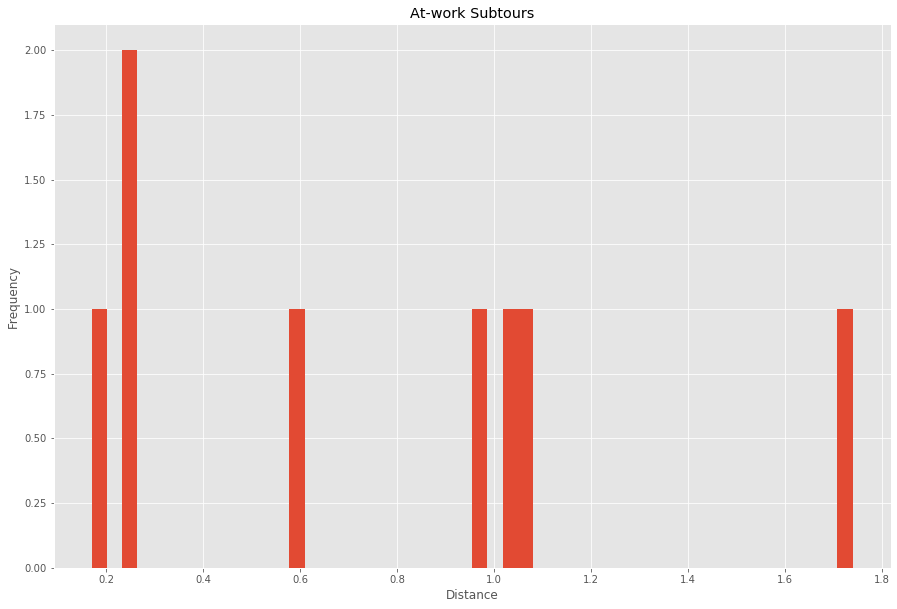

In [61]:
ATW_TOURS = TOUR[TOUR["tour_category"] == "atwork"]
ATW_TOURS["distance"] = DIST_MAT[ATW_TOURS["origin"].astype(int)-1,
                                 ATW_TOURS["destination"].astype(int)-1]
ATW_TOURS["dist_bin"] = pd.cut(ATW_TOURS["distance"], range(51))
atw_tours_dist = ATW_TOURS.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(atw_tours_dist, 'atwork_dist.csv')
plt.hist(ATW_TOURS["distance"], bins=50)
plt.title('At-work Subtours')
plt.ylabel('Frequency')
_ = plt.xlabel('Distance')

## At-work subtour scheduling

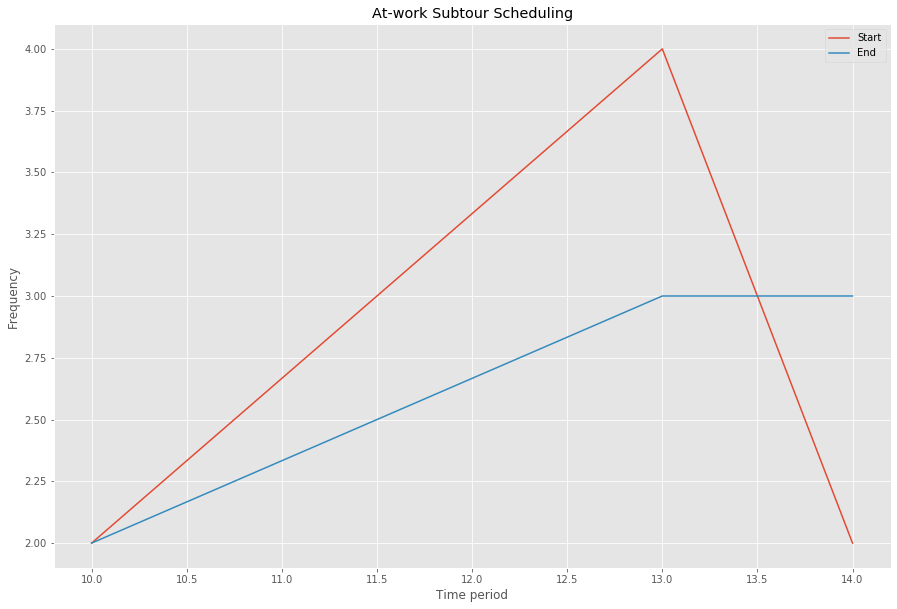

In [72]:
atw_tours_tdd = ATW_TOURS.groupby(["start", "end"]).count()["household_id"].reset_index()
atw_tours_tdd = atw_tours_tdd.pivot_table(index="start", columns="end", fill_value=0)['household_id']

save_verf_csv(atw_tours_tdd, 'atwork_tours_tdd.csv')

plt.plot(atw_tours_tdd.sum(axis=1), label='Start')
plt.plot(atw_tours_tdd.sum(axis=0), label='End')
plt.title('At-work Subtour Scheduling')
plt.ylabel('Frequency')
plt.xlabel('Time period')
_ = plt.legend(loc='best')

## Tour stop frequency

In [63]:
nmn_tours = TOUR[(TOUR["tour_category"] == "mandatory") |
                 (TOUR["tour_category"] == "non_mandatory")]
stop_freq = nmn_tours.groupby(["stop_frequency", "tour_type"]).count()["household_id"].reset_index()
stop_freq = stop_freq.pivot(index="stop_frequency", columns="tour_type")

stop_freq_joint = JOINT_TOURS.groupby(["stop_frequency"]).count()["household_id"]
stop_freq_atwork = ATW_TOURS.groupby(["stop_frequency"]).count()["household_id"]
stop_freq = pd.concat([stop_freq, stop_freq_joint, stop_freq_atwork], axis=1, sort=True)

save_verf_csv(stop_freq, 'stop_freq.csv')

stop_freq

,"(household_id, eatout)","(household_id, escort)","(household_id, othdiscr)","(household_id, othmaint)","(household_id, school)","(household_id, shopping)","(household_id, social)","(household_id, work)",household_id,household_id
0out_0in,15.0,3.0,18.0,16.0,18.0,22.0,5.0,52.0,3.0,4.0
0out_1in,NaN,NaN,NaN,NaN,5.0,3.0,1.0,4.0,NaN,1.0
0out_2in,NaN,NaN,NaN,1.0,NaN,2.0,NaN,4.0,NaN,NaN
0out_3in,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1out_0in,1.0,NaN,1.0,1.0,1.0,2.0,NaN,4.0,NaN,1.0
1out_1in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1out_3in,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2out_0in,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2out_2in,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3out_0in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0


# Trips

## Trip purpose

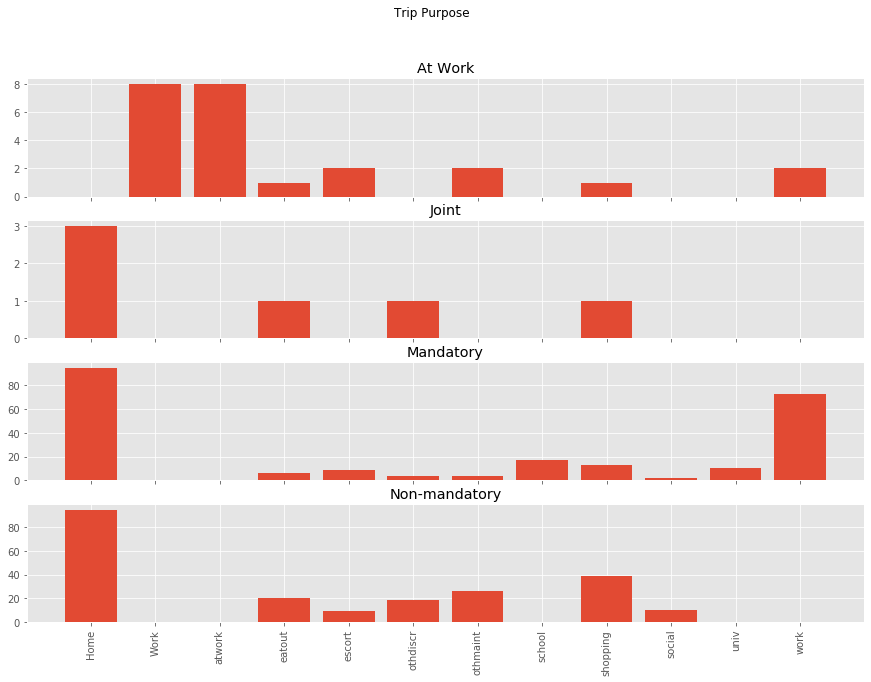

In [64]:
TRIP["tour_category"] = TOUR["tour_category"].loc[TRIP["tour_id"]].tolist()
trip_purp = TRIP.groupby(["purpose", "tour_category"]).count()["household_id"].reset_index()
trip_purp = trip_purp.pivot_table(index="purpose", columns="tour_category", fill_value=0)['household_id']

save_verf_csv(trip_purp, 'trip_purp.csv')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Trip Purpose')
ax1.bar(trip_purp.index, trip_purp['atwork'])
ax1.set_title('At Work')
ax2.bar(trip_purp.index, trip_purp['joint'])
ax2.set_title('Joint')
ax3.bar(trip_purp.index, trip_purp['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(trip_purp.index, trip_purp['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')

## Trip Destination

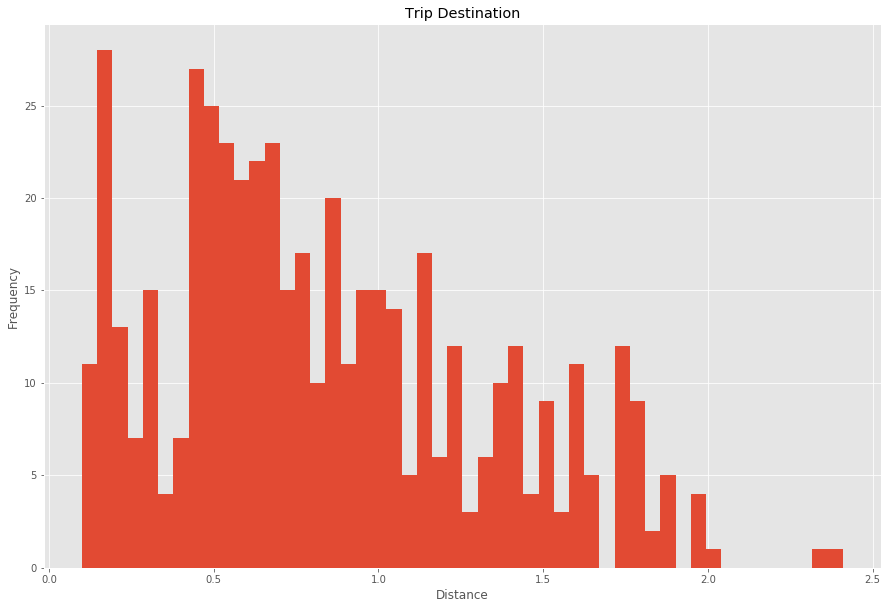

In [65]:
TRIP["distance"] = DIST_MAT[TRIP["origin"]-1, TRIP["destination"]-1]
TRIP["dist_bin"] = pd.cut(TRIP["distance"], range(51))
trips_dist = TRIP.groupby(["dist_bin"]).count()["household_id"]

save_verf_csv(trips_dist, 'trips_dist.csv')
plt.hist(TRIP["distance"], bins=50)
plt.title('Trip Destination')
plt.ylabel('Frequency')
_ = plt.xlabel('Distance')

c:\programdata\anaconda3\envs\asimtest\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


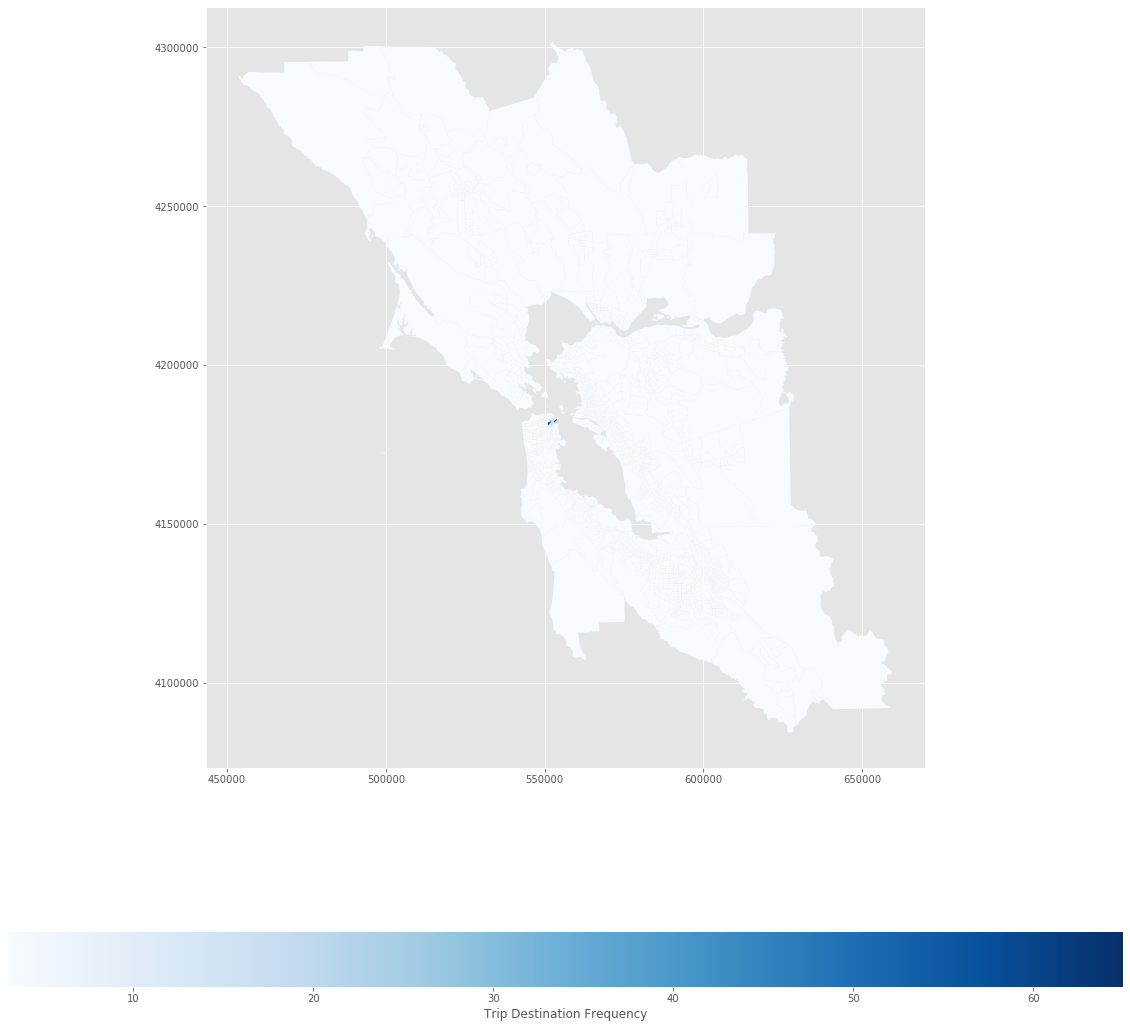

In [66]:
trip_dests = TRIP.groupby(['destination']).count()['household_id']
trip_shapes = SHAPES.merge(trip_dests.reset_index(), how='left', left_on='TAZ1454', right_on='destination')
trip_shapes.plot(column='household_id',
                 cmap='Blues',
                 figsize=(20,20),
                 legend=True,
                 legend_kwds={'label': 'Trip Destination Frequency', 'orientation': "horizontal"})

## Trip scheduling

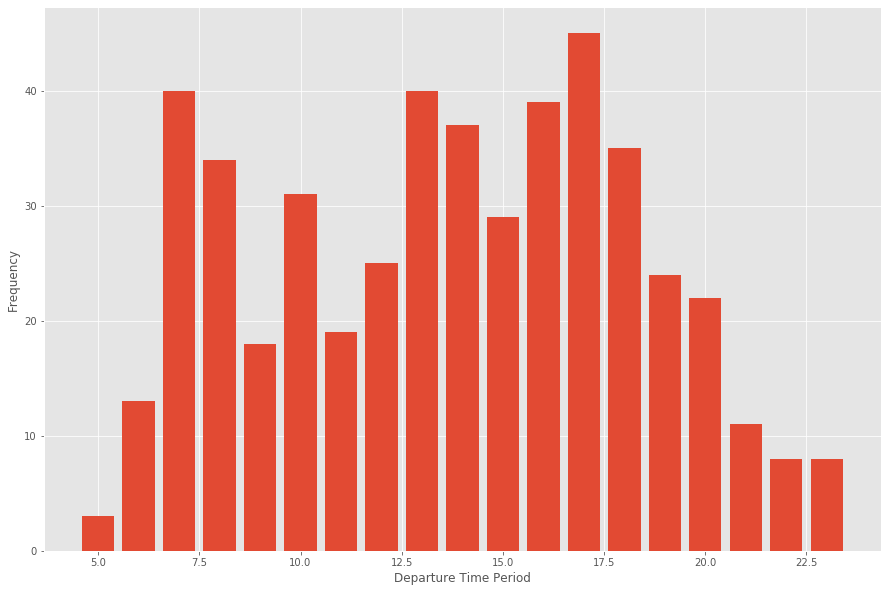

In [67]:
trips_tdd = TRIP.groupby(["depart"]).count()["household_id"]

save_verf_csv(trips_tdd, 'asim_trips_depart.csv')
plt.bar(trips_tdd.index, trips_tdd.values)
plt.xlabel('Departure Time Period')
_ = plt.ylabel('Frequency')

## Trip mode share by tour purpose

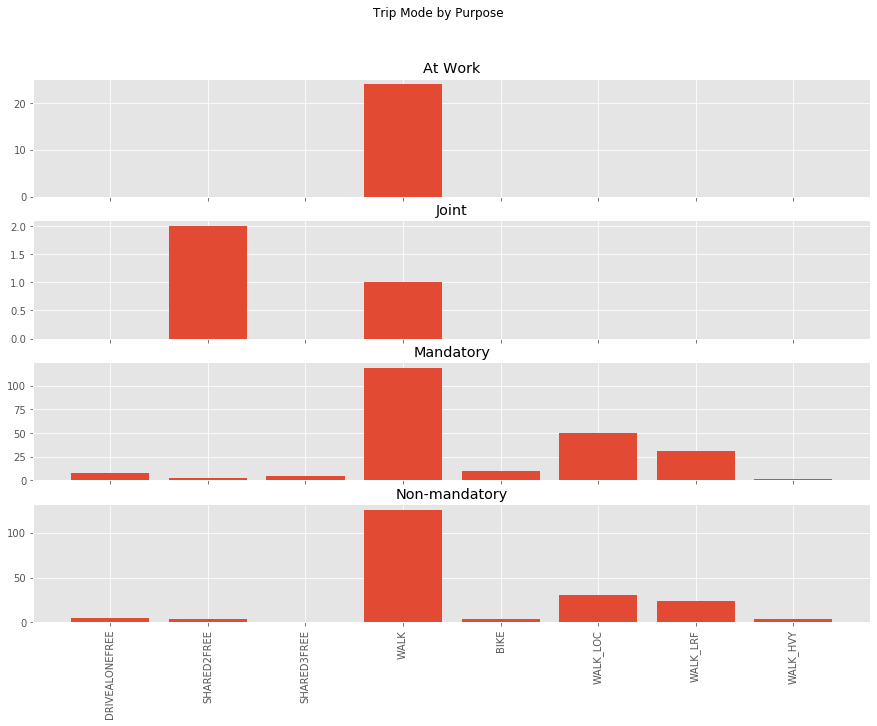

In [68]:
trip_mode = TRIP.groupby(["trip_mode", "tour_category"]).count()["household_id"].reset_index()
trip_mode = trip_mode.pivot_table(index="trip_mode", columns="tour_category", fill_value=0)['household_id']

save_verf_csv(trip_mode, 'trip_mode.csv')


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Trip Mode by Purpose')
ax1.bar(trip_mode.index, trip_mode['atwork'])
ax1.set_title('At Work')
ax2.bar(trip_mode.index, trip_mode['joint'])
ax2.set_title('Joint')
ax3.bar(trip_mode.index, trip_mode['mandatory'])
ax3.set_title('Mandatory')
ax4.bar(trip_mode.index, trip_mode['non_mandatory'])
ax4.set_title('Non-mandatory')
_ = plt.xticks(rotation='vertical')